In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, classification_report, roc_auc_score,
    confusion_matrix, roc_curve)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

# -------------------------------
# 1. Load Dataset & Add Features
# -------------------------------
df = pd.read_csv("data/preprocessed_loan_data.csv")
display(df.head())

,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Default,...,EmploymentType_Unemployed,MaritalStatus_Married,MaritalStatus_Single,HasMortgage_Yes,HasDependents_Yes,LoanPurpose_Business,LoanPurpose_Education,LoanPurpose_Home,LoanPurpose_Other,HasCoSigner_Yes
0,0,0,-1,0,0,1,0,0,0,0,...,0,0,0,1,1,0,0,0,1,1
1,1,0,0,0,-1,-1,-1,1,0,0,...,0,1,0,0,0,0,0,0,1,1
2,0,0,0,0,0,0,1,0,0,1,...,1,0,0,1,1,0,0,0,0,0
3,0,-1,-1,1,-1,0,0,0,-1,0,...,0,1,0,0,0,1,0,0,0,0
4,1,-1,-1,0,-1,1,-1,0,0,0,...,1,0,0,0,1,0,0,0,0,0


C:\Users\enuzo\Documents\Project Portfolio\machine_learning\loan_prediction\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:48:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Model training complete.
📈 Accuracy: 0.8277
📉 ROC AUC Score: 0.6799
📊 Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.91      0.90     45139
           1       0.24      0.23      0.24      5931

    accuracy                           0.83     51070
   macro avg       0.57      0.57      0.57     51070
weighted avg       0.82      0.83      0.83     51070



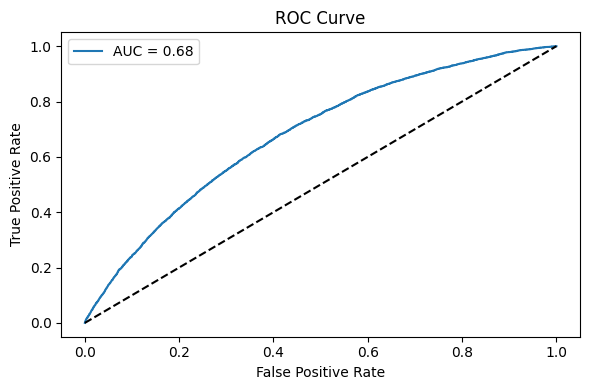

💾 Model, scaler, and risk thresholds saved to /models/


In [2]:

# Add engineered features
df["LoanToIncome"] = df["LoanAmount"] / (df["Income"] + 1)
df["EmploymentDurationRatio"] = df["MonthsEmployed"] / (df["Age"] * 12 + 1)

# Handle any missing/infinite values
df.replace([np.inf, -np.inf], 0, inplace=True)
df.fillna(0, inplace=True)

# -------------------------------
# 2. Split Features and Target
# -------------------------------
X = df.drop(columns=["Default"])
y = df["Default"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# -------------------------------
# 3. Scale Numeric + Engineered Features
# -------------------------------
numeric_cols = ['Age', 'Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed',
                'NumCreditLines', 'InterestRate', 'LoanTerm', 'DTIRatio',
                'LoanToIncome', 'EmploymentDurationRatio']


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[numeric_cols])
X_test_scaled = scaler.transform(X_test[numeric_cols])

X_train[numeric_cols] = X_train[numeric_cols].astype(float)
X_test[numeric_cols] = X_test[numeric_cols].astype(float)

# Replace scaled columns
X_train.loc[:, numeric_cols] = X_train_scaled
X_test.loc[:, numeric_cols] = X_test_scaled

# -------------------------------
# 4. Balance Training Data with SMOTE
# -------------------------------
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# -------------------------------
# 5. Train Model (XGBoost)
# -------------------------------
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_resampled, y_resampled)

# -------------------------------
# 6. Evaluate Model
# -------------------------------
y_probs = model.predict_proba(X_test)[:, 1]
y_pred = (y_probs >= 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_probs)
report = classification_report(y_test, y_pred)

print("✅ Model training complete.")
print("📈 Accuracy:", round(accuracy, 4))
print("📉 ROC AUC Score:", round(roc_auc, 4))
print("📊 Classification Report:\n", report)

# -------------------------------
# 7. Visualize Confusion Matrix
# -------------------------------
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Non-Default", "Default"],
            yticklabels=["Non-Default", "Default"])
plt.title("Confusion Matrix (Threshold = 0.5)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig("models/confusion_matrix.png")
plt.close()

# -------------------------------
# 8. Plot ROC Curve
# -------------------------------
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.tight_layout()
plt.savefig("models/roc_curve.png")
plt.show()
plt.close()

# -------------------------------
# 9. Save Artifacts
# -------------------------------
joblib.dump(model, "models/credit_risk_model.pkl")
joblib.dump(scaler, "models/scaler.pkl")

# Save thresholds for 4-level risk segmentation
risk_thresholds = {
    'low': 0.30,
    'medium': 0.50,
    'high': 0.75
}
joblib.dump(risk_thresholds, "models/risk_thresholds.pkl")
print("💾 Model, scaler, and risk thresholds saved to /models/")
